<a href="https://colab.research.google.com/github/MiroDur/MuScat_Miro/blob/master/DataReconstructionFromSimCell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install phantominator
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 5.8MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


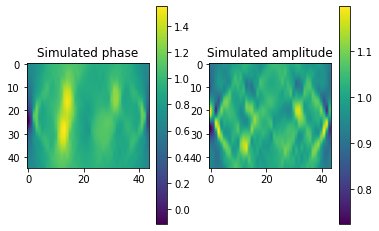

0.47479677200317383


In [45]:
import sys
sys.path.append('/content/drive/My Drive/MuScat')
from MuScatObject import MuScatObject
from MuScatField import MuScatField
from MuScatParameters import MuScatParameters
from MuScatMicroscopeSim import MuScatMicroscopeSim
import tensorflow as tf
import tensorflow_addons as tfa
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io



# ==========================================================
# MAKE SURE THAT X AND Y SIZE OF THE GRID FOR SIMULATION IS EVEN!!!
# I probably assumed that in the implementation from the begining
# ==========================================================

# NOA63 glue - refractive index = 1.5559 at 650nm
# soda-lime glass - refractive index = 1.5210 at 650nm - questionable for my spheres
# PVP (gel) - refractive index = 1.5245 at 650nm
# PVA (gel) - refractive index = 1.4757 at 650nm
# water - refractive index = 1.3310 at 650nm

refrIndM = 1.331
start = time.time()
# Illumination in most of the cases with 20x objective with NA=0.5
# Detection with 40x objective NA=0.95
parameters = MuScatParameters(0.650,        # wavelength in vacuum
                              [45, 44, 44], # gridSize [z, x ,y]
                              0.15787*2,          # dx
                              0.15787*2,          # dy
                              0.2*refrIndM,          # dz
                              refrIndM,          # refractive index in medium
                              0.5,          # NAc
                              0.95)          # NAo
zsampling = 1

regLambdaL1 = 0.0003
regLambdaL2 = 0.000
regLambdaTV = 0.00003
learnRate = 0.8

centerInd = np.int32(parameters.gridSize[1]/2)

imagingSim = MuScatMicroscopeSim(parameters)

MuScatMethod = 'MLB'
shift1 = 0.5
refShifts = tf.cast(tf.constant([[shift1, shift1],[0., 0.],[-shift1, shift1],[shift1, -shift1], [-shift1, -shift1]]), tf.float32)
refShifts = tf.cast(tf.constant([[0., 0.]]), tf.float32)
#refShifts = tf.cast(tf.constant([[0.,shift1]]), tf.float32)
# Initialize Illumination and detection part
imagingSim.Illumination(HollowCone = 0.1)
imagingSim.Detection()

# Initialize object containing refractive index Variable-Tensor to be optimized
optimizedObject = MuScatObject(parameters)

# Define focal positions for z-Stack creation
zPositions = optimizedObject.realzzz[::zsampling,0,0] - optimizedObject.realzzz[0,0,0]

# Create object that will be imaged in case of pure simulation
imagedObject = MuScatObject(parameters)
imagedObject.GenerateElipsoidNP(6.5, 6.5, 4.5, [0.,0.,0.], 1.37) # cell border
imagedObject.GenerateElipsoidNP(6., 6., 4., [0.,0.,0.], 1.34)   # cell inside
imagedObject.GenerateElipsoidNP(2., 3.5, 2.5, [1.,1.,1.], refrIndM)  # zero diff
imagedObject.GenerateElipsoidNP(1., 1.5, 1., [1.5,0.,1.5], 1.35)  # nucleus
imagedObject.GenerateSphereNP(0.5, [-3.,-1.,-1.5], 1.37)   # small features
imagedObject.GenerateSphereNP(0.5, [-2.,0.,-2.5], 1.37)
imagedObject.GenerateSphereNP(0.5, [-2.,-3.,-0.], 1.37)
imagedObject.GenerateSphereNP(0.5, [2.,0.,-3.], 1.37)
imagedObject.GenerateSphereNP(0.5, [-2.,0.,3.], 1.37)

# Simulate light propagation through defined imagedObject
fieldSimulated = MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
    imagedObject, method=MuScatMethod)

# Generate z-Stack measurement with CCHM from simulated scattered field
zStackSimulated = imagingSim.CCHMImaging(fieldSimulated, zPositions, refShifts) 

# in case of imaging a Bead, check validity of set parameters based on the 
# comparison of simulated and measured data
plt.figure(11)
plt.subplot(121),plt.colorbar(plt.imshow(
    np.angle(zStackSimulated[0, :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Simulated phase')
plt.subplot(122),plt.colorbar(plt.imshow(
    np.abs(zStackSimulated[0, :, centerInd, :]),
    aspect=parameters.dz/parameters.dx))
plt.title('Simulated amplitude')

plt.show()

# in case of Adam or other TF optimizers use this regularizer func. to
# specify L1 and L2 regularization
regularizer = tf.keras.regularizers.L1L2(regLambdaL1, regLambdaL2)
#opt = tf.keras.optimizers.Adam(learning_rate=learnRate)

# Some optimizers such as Yogi have l1 and l2 as parameters
# Yogi is steepest gradient descent based optimizer
# ProximalAdagrad
opt = tfa.optimizers.ProximalAdagrad(learning_rate=learnRate,
                          l1_regularization_strength = regLambdaL1,
                          l2_regularization_strength = regLambdaL2)

def regTV(variable, parameter):
    diffZ = (variable - tf.roll(variable,1,0))
    diffX = (variable - tf.roll(variable,1,1))
    diffY = (variable - tf.roll(variable,1,2))
    return parameter * tf.reduce_sum(tf.sqrt(diffZ**2 + diffX**2 + diffY**2 + \
                                             tf.keras.backend.epsilon()))


@tf.function
def loss_fn(zStackSimulated, zStackMeasured):
    return tf.reduce_mean(tf.abs(zStackMeasured - zStackSimulated)**2) #+ regTV(optimizedObject.RIDistrib, regLambdaTV)
        #regularizer(optimizedObject.RIDistrib) #+ regTV(optimizedObject.RIDistrib, 0.0005)


loss = lambda: loss_fn(imagingSim.CCHMImaging(
    MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
        optimizedObject, method=MuScatMethod),
        zPositions,
        refShifts),
        zStackSimulated)

lossF = [ ]
for i in range(00):
    opt_op = opt.minimize(loss, var_list=[optimizedObject.RIDistrib])
    if i%5==0:
        #lossF.append(loss().numpy())
        plt.figure(1)
        plt.subplot(121),plt.colorbar(plt.imshow(
            optimizedObject.RIDistrib[:, centerInd, :],
            aspect=parameters.dz/parameters.dx))
        plt.title('Refractive index')
        plt.subplot(122),plt.colorbar(plt.imshow(
            imagedObject.RIDistrib[:, centerInd, :],
            aspect=parameters.dz/parameters.dx))
        plt.title('Refractive index reality')
        plt.tight_layout(pad=3.0)
        #plt.subplot(133),plt.plot(lossF)
        plt.show()

print(time.time()-start)

In [41]:
!pip install pyevtk
from pyevtk.hl import gridToVTK
from pyevtk.hl import imageToVTK
#gridToVTK(
#    "./RIDistrib",
#    imagedObject.realzzz.numpy(),
#    imagedObject.realxxx.numpy(),
#    imagedObject.realyyy.numpy(),
#    pointData={"RIDistrib": optimizedObject.RIDistrib.numpy()},
#    )

imageToVTK(
    "./RIDistribSimCELL_Zstack",
    spacing = (parameters.dz/parameters.dx,1.0,1.0),
    cellData={"RIDistrib": imagedObject.RIDistrib.numpy()},
    
)


'/content/RIDistribSimCELLGroundTruth.vti'

InvalidArgumentError: ignored

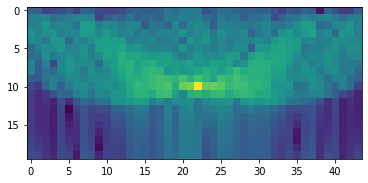

<Figure size 432x288 with 0 Axes>

In [11]:

plt.figure(5),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[0, :, centerInd, :]))))))
plt.figure(6),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[1, :, centerInd, :]))))))
plt.figure(7),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[2, :, centerInd, :]))))))
plt.figure(8),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[3, :, centerInd, :]))))))
plt.figure(9),plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fftn(np.squeeze(zStackSimulated[4, :, centerInd, :]))))))

print(refShifts)
#print(zStckShape)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fbf4f264e48>)

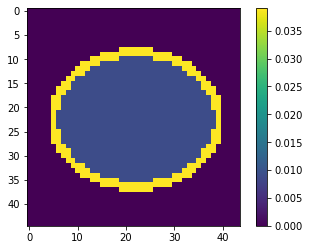

In [33]:
plt.figure(105),plt.colorbar(plt.imshow(imagedObject.RIDistrib[:, 32, :]))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1f727305f8>,
 <matplotlib.colorbar.Colorbar at 0x7f1f725450b8>)

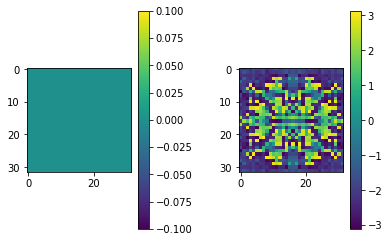

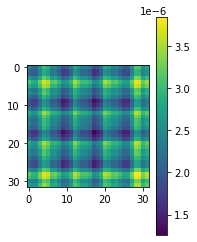

In [3]:
zStackSim = imagingSim.CCHMImaging(
    MuScatField(imagingSim.planeWaves, parameters).ComputeMuScat(
        optimizedObject, method=MuScatMethod),
        zPositions,
        refShifts)
plt.figure(55)
plt.subplot(121),plt.colorbar(plt.imshow(optimizedObject.RIDistrib[21, :, :]))
plt.subplot(122),plt.colorbar(plt.imshow(np.angle(zStackSimulated[0, 21, :, :])))

plt.tight_layout(pad=3.0)
plt.figure(56)
plt.subplot(121),plt.colorbar(plt.imshow(np.angle(zStackSim[0, 21, :, :])))